# Left/Right visual field stimulation with Muse

In this experiment, participants were presented with gratings in either their left or right visual fields.

Stimuli were presented for 200 ms with an intertrial interval of 250 ms and random jitter of ±50ms. The task was to fixate the center of the screen while the stimuli were displayed in either the left or right visual fields. Six blocks of 2 min were recorded for a single partipant.

The stimuli were gratings with random phase.

In [1]:
import sys
from collections import OrderedDict

from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage

import pandas as pd
import numpy as np

from glob import glob
import seaborn as sns
from matplotlib import pyplot as plt

sys.path.append('../muse')
import utils

%matplotlib inline

## Load data into MNE objects

In [2]:
subject = 'all'
session = 1
raw = utils.load_data('visual/left-right', sfreq=256., 
                      subject_nb=subject, session_nb=session, 
                      ch_ind=[0, 1, 2, 3])

Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ...   120.043 secs
Ready.
Creating RawArray with float64 data, n_channels=5, n_times=30732
    Range : 0 ... 30731 =      0.000 ..

## Power Spectrum

Effective window size : 8.000 (s)


/usr/local/lib/python3.5/dist-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


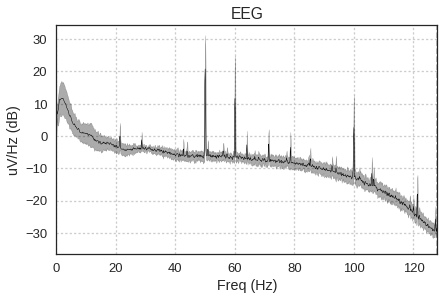

In [3]:
raw.plot_psd(tmax=np.inf);

## Filtering

We filter data between 1 and 30 Hz

In [4]:
raw.filter(1, 30, method='iir')

Setting up band-pass filter from 1 - 30 Hz


<RawArray  |  None, n_channels x n_times : 5 x 338052 (1320.5 sec), ~12.9 MB, data loaded>

## Epoching

Here we epoch data for -100 ms to 500 ms after the stimulus. No baseline correction is needed (signal is bandpass filtered) and we reject every epochs were the signal exceeds 100 uV.

In [5]:
from mne import Epochs, find_events

events = find_events(raw)
event_id = {'Left': 1, 'Right': 2}

epochs = Epochs(raw, events=events, event_id=event_id, tmin=-0.1, tmax=0.5, 
                baseline=None, reject={'eeg': 100e-6}, preload=True, 
                verbose=False, picks=[0, 1, 2, 3], add_eeg_ref=False)
epochs

2850 events found
Events id: [1 2]


<Epochs  |  n_events : 2785 (all good), tmin : -0.1015625 (s), tmax : 0.5 (s), baseline : None, ~13.2 MB, data loaded,
 'Left': 1386, 'Right': 1399>

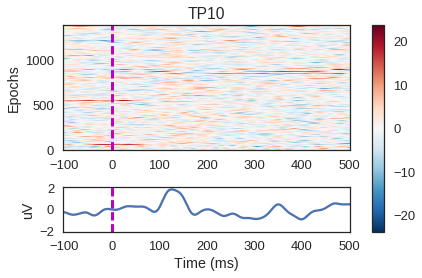

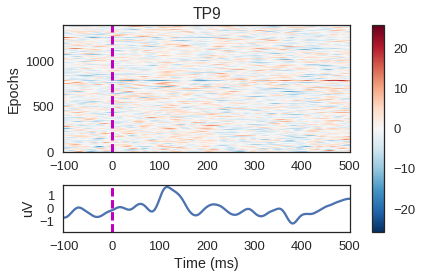

In [12]:
epochs['Left'].plot_image(picks=[3], sigma=1);
epochs['Right'].plot_image(picks=[0], sigma=1);

## Epoch average

Now we can plot the average ERP for both condition, and see if there is something. We expect a contralateral C1 and P1 response.

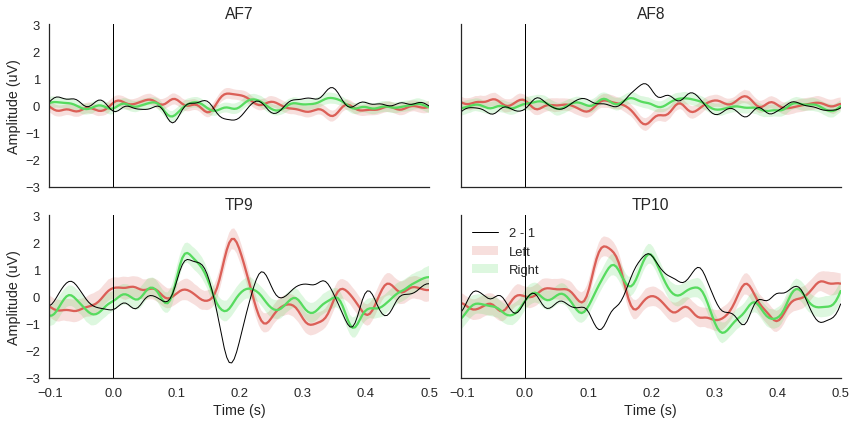

In [6]:
conditions = OrderedDict()
conditions['Left'] = [1]
conditions['Right'] = [2]

fig, ax = utils.plot_conditions(epochs, conditions=conditions, 
                                ci=97.5, n_boot=1000, title='',
                                diff_waveform=(1, 2), ylim=(-3, 3))

As we can see, there is a clear and identifiable difference between the left and right visual field stimulation. It seems to be visible on the frontal and temporo-parietal channels.

## Decoding

Here is will use 4 different pipelines to classify between the two conditions:

- **Vect + LR** :  Vectorization of the trial + Logistic Regression. This can be considered as the standard decoding pipeline in MEG / EEG.
- **Vect + RegLDA** :  Vectorization of the trial + Regularized LDA. This one is very used in P300 BCI. It can outperform the previous one but can become unusable if the number of dimension is too high.
- **ERPCov + TS**: ErpCovariance + Tangent space mapping. One of my favorite Riemannian geometry based pipeline.
- **ERPCov + MDM**: ErpCovariance + MDM. A very simple, yet effective (for low channel count), Riemannian geometry classifier.

Evaluation is done in cross-validation, with AUC as metric (AUC is probably the best metric for binary and unbalanced classification problem)

In [7]:
from sklearn.pipeline import make_pipeline

from mne.decoding import Vectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

from sklearn.model_selection import cross_val_score, StratifiedShuffleSplit

from pyriemann.estimation import ERPCovariances, XdawnCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.classification import MDM

from collections import OrderedDict

clfs = OrderedDict()

clfs['Vect + LR'] = make_pipeline(Vectorizer(), StandardScaler(), LogisticRegression())
clfs['Vect + RegLDA'] = make_pipeline(Vectorizer(), LDA(shrinkage='auto', solver='eigen'))
clfs['ERPCov + TS'] = make_pipeline(ERPCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['ERPCov + MDM'] = make_pipeline(ERPCovariances(estimator='oas'), MDM())
clfs['XdawnCov + TS'] = make_pipeline(XdawnCovariances(estimator='oas'), TangentSpace(), LogisticRegression())
clfs['XdawnCov + MDM'] = make_pipeline(XdawnCovariances(estimator='oas'), MDM())

# format data
epochs.pick_types(eeg=True)
X = epochs.get_data() * 1e6
times = epochs.times
y = epochs.events[:, -1]

# define cross validation 
cv = StratifiedShuffleSplit(n_splits=20, test_size=0.25, 
                            random_state=42)

# run cross validation for each pipeline
auc = []
methods = []
for m in clfs:
    print(m)
    try:
        res = cross_val_score(clfs[m], X, y==2, scoring='roc_auc', 
                              cv=cv, n_jobs=-1)
        auc.extend(res)
        methods.extend([m]*len(res))
    except:
        pass
    
results = pd.DataFrame(data=auc, columns=['AUC'])
results['Method'] = methods

Vect + LR
Vect + RegLDA
ERPCov + TS
ERPCov + MDM
XdawnCov + TS
XdawnCov + MDM


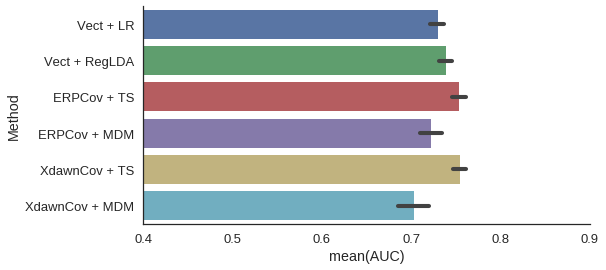

In [8]:
fig = plt.figure(figsize=[8, 4])
sns.barplot(data=results, x='AUC', y='Method')
plt.xlim(0.4, 0.9)
sns.despine()